# Image-to-Image Translation with CycleGAN
Notebook Author: Jin Yeom (jinyeom@utexas.edu)  
Original Authors: Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros

In [2]:
import os
import zipfile

import torch
import torchvision
from torchvision import transforms
from torchvision import datasets

import numpy as np
import wget
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline

![CycleGAN](images/cyclegan.jpg)

## Datasets

In [3]:
def download_dataset(name: str):
    if name not in ["ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", 
                    "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", 
                    "cityscapes", "facades", "iphone2dslr_flower", "ae_photos"]:
        raise ValueError("invalid argument dataset name")
        
    if not os.path.exists("./datasets"):
        print("Datasets directory not found, creating a new directory 'datasets'...")
        os.mkdir("./datasets")
    zip_path = "./datasets/{}.zip".format(name)
    target_dir = "./datasets/{}/".format(name)
    
    url = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{}.zip".format(name)
    wget.download(url, out=zip_path)
    
    os.mkdir(target_dir)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("datasets/")
    os.remove(zip_path)

In [4]:
# NOTE: only download if you have to!
download_dataset("apple2orange")
download_dataset("horse2zebra")

Datasets directory not found, creating a new directory 'datasets'...


In [3]:
!ls ./datasets

apple2orange  horse2zebra


In [6]:
!ls ./datasets/horse2zebra/

testA  testB  trainA  trainB


Here, we're going to load the downloaded datasets to work with via **torchvision**. Since the data images are already nicely sized and cropped uniformly, the only transformation we have to do further is normalization.

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

horse2zebra = datasets.ImageFolder(root="./datasets/horse2zebra", transform=transform)
data_loader = torch.utils.data.DataLoader(horse2zebra, batch_size=16, shuffle=True, num_workers=2)

Now, let's sample some images, and see what they look like!

In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

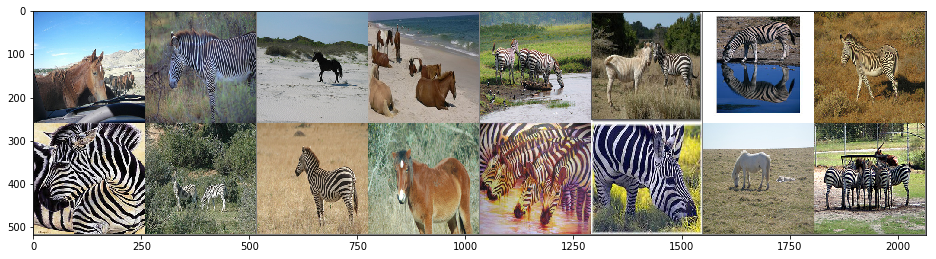

In [18]:
images, labels = iter(data_loader).next()
imshow(torchvision.utils.make_grid(images))

## Model

![model](images/CycleGAN.png)

## Generator network

In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(ResBlock, self).__init__()
        self.pad = torch.nn.ReflectionPad2d((kernel_size - 1) // 2)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.norm1 = torch.nn.InstanceNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride)
        self.norm2 = torch.nn.InstanceNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.pad(x)
        z = self.conv1(z)
        z = self.norm1(x)
        z = self.relu(z)
        z = self.pad(z)
        z = self.conv2(z)
        z = self.norm2(z)
        return x + z

In [18]:
class Generator(nn.Module):
    def __init__(self, in_channel: int, out_channel: int):
        super(Generator, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.model = torch.nn.Sequential(
            # encoder
            torch.nn.ReflectionPad2d(3), 
            torch.nn.Conv2d(in_channel, 32, 7, 1),
            torch.nn.InstanceNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, 2),
            torch.nn.InstanceNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.InstanceNorm2d(128),
            torch.nn.ReLU(),
            # transformer
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            ResBlock(128, 128, 3, 1),
            # decoder
            # TODO: switch from deconvolution to resize-convolution upsampling
            # to avoid checkerboard artifacts (https://distill.pub/2016/deconv-checkerboard/)
            torch.nn.ConvTranspose2d(128, 64, 3, 2), 
            torch.nn.ReLU(),
            torch.nn.InstanceNorm2d(64),
            torch.nn.ConvTranspose2d(64, 32, 3, 2),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d(3),
            # output
            torch.nn.Conv2d(32, 3, 7, 1), 
            torch.nn.InstanceNorm2d(3),
            torch.nn.Tanh())
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

## Descriminator network

In [12]:
class Descriminator(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Discriminator, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.model = nn.Sequential(
            torch.nn.Conv2d(in_channel, 64, 7, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 7, 2),
            torch.nn.InstanceNorm2d(128),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, 7, 2),
            torch.nn.InstanceNorm2d(256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 512, 7, 2),
            torch.nn.InstanceNorm2d(512),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(512, out_channel, 7, 1))
        
    def forward(self, x):
        return self.model(x)

## Losses

Two types of loss functions are used to train CycleGAN models: **adversarial losses** for matching the distribution of generated images to the data distribution in the target domain (since we're mapping $A$ to $B$ and $B$ to $A$, we need two adversarial loss functions, $G_{AB}: A \rightarrow B$ and $G_{BA}: B \rightarrow A$); and **cycle consistency losses** to prevent the learned mappings between the two input domains from contradicting each other. The loss functions are expressed as follows,

$$\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) = 
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log D_B(b) \big] +
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log(1 - D_B(G(a))) \big]$$

$$\mathcal{L}_{GAN}(G_{BA}, D_A, B, A) = 
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log D_A(a) \big] +
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log(1 - D_A(G(b))) \big]$$

$$\mathcal{L}_{cyc}(G_{XY}, G_{YX}) = 
    \mathbb{E}_{x \sim p_{data(x)}}
        \big[ {\left\lVert G_{YX}(G_{XY}(x)) - x \right\rVert}_1 \big] +
    \mathbb{E}_{y \sim p_{data(y)}}
        \big[ {\left\lVert G_{XY}(G_{YX}(y)) - y \right\rVert}_1 \big]$$

and finally,

$$\mathcal{L}(G_{AB}, G_{BA}, D_A, D_B) = 
    \mathcal{L}_{GAN}(G_{AB}, D_B, A, B)
    + \mathcal{L}_{GAN}(G_{BA}, D_A, B, A)
    + \lambda\mathcal{L}_{cyc}(G_{XY}, G_{YX})$$

Note that the adversarial loss is essentially the **binary cross entropy** between outputs of a discriminator network from real and fake data. Also note that Zhu et al. state in their paper that using a **least-squares loss** instead of the negative log likelihood (BCE) improved stability during training and generates higher quality result. We'll try them ourselves and see the difference!

In [25]:
adv_loss_bce = torch.nn.BCELoss() # binary cross entropy (negative log likelihood)
adv_loss_mse = torch.nn.MSELoss() # mean squared error (least-squares loss)

## References
1. https://arxiv.org/pdf/1703.10593.pdf (Orignal CycleGAN paper)
2. https://arxiv.org/pdf/1603.08155v1.pdf (Perceptual losses and image transformation network)
3. https://arxiv.org/pdf/1607.08022.pdf (Instance normalization)
4. 